# RESCUE
**Renewable Energy Salient Combined Uncertainty Estimator**

## *Description:*
A machine-learning based framework to quantify the short-term uncertainty in netload forecast developed by E3. 
The main structure of the model include a multi-layer artificial neural net with the pinball loss function as objective. Conditional on combinations of input, the model is able to output quantile forecast for the net-load forecast error.

This notebook contains the work stream of ingesting pre-processed data, set up cross validation folds, training and deployment, and calling functions for diagnostics. For detailed implementation of data preprocessing or quoted functions, please refer to other script files. This project is available in the [e3/RESCUE](https://github.com/e3-/RESCUE) Github online repository. 

RESCUE model supports multi-objective learning. For example, in addition to producing the quantile forecast of Net Load forecast error, it can be trained to simultaneously predict the Load, Solar and Wind forecast error. The objectives can be weighted per user's judgement of relative importance.

Special note on CAISO use case: In other cases, the quantile forecast is trained on forecast errors, and represent the probablity distribution of forecast errors. For CAISO, as we are using RTPD forecast - RTD forecast as the response variable, it represents the distribution on forecast difference rather than forecast error. Nevertheless, the model structure and the logic still holds the same. 
## *Highlights:*
1. Incorporating a wide gamut of information: weather, calendar, forecast, and lagged error aware. 
2. Intrinsically handles resource correlation as solar,wind, and load errors are co-trained within the model.
3. Produces multiple prediction intervals for expected error in netload, load, solar and wind forecasting, for cherry picking down-stream
4. Model agnostic. No requirement on knowledge of the inner workings of the netload forecast
5. Adheres to best practice in statistics: cross validation, normalization, early-stopping, etc.

## *To-dos:*
1. Standardize the output for stability;
3. Make actual reserves data part of dir_str if we foresee comparing model predictions to actual reserves in future work

## *Authors:* 
Yuchi Sun, Vignesh Venugopal, Charles Gulian

In [1]:
# Import third party packages
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import functools

# Import self defined packages
import cross_val
import utility
import diagnostics
import metrics

# Pareto Plotting

Takes input of a list of models to compare; grabs pred_trainval and input_trainval for each model, as well as validation masks; looking at validation-set only predictions for each CV fold, compares:

- Coverage
- Requirement
- Standard Deviation of Coverage and Requirement
- Deviation of Coverage from Target Coverage

for all available $\tau$-levels for net load forecast error prediction.

In [55]:
models_to_compare = ['rescue_v1_1_multi_objective', 'rescue_v1_3'] # List of models to compare; must be multi-objective models
metrics_to_compare = ['coverage', 'requirement', 'pinball_loss'] # List of metrics to compare

# Get pred_trainval, output_trainval, and val_masks_all_folds for all models
model_data_dict = {model_name: {} for model_name in models_to_compare}
for model_name in models_to_compare:
    
    # Load in/ Create folder structure for the current model
    dir_str = utility.Dir_Structure(model_name = model_name)

    # Read in predictions, targets, and validation masks for the current model
    pred_trainval = pd.read_pickle(dir_str.pred_trainval_path)
    output_trainval = pd.read_pickle(dir_str.output_trainval_path)
    val_masks_all_folds = cross_val.get_CV_masks(output_trainval.index, num_cv_folds, dir_str.shuffled_indices_path)
    
    # Save to data dictionary
    model_data_dict[model_name]['pred'] = pred_trainval
    model_data_dict[model_name]['output'] = output_trainval
    model_data_dict[model_name]['masks'] = val_masks_all_folds
    
    # Get CV fold metrics; passing "val_masks_all_folds" will compute metrics only on validation set data
    df_metrics = metrics.compute_metrics_for_all_taus(output_trainval, 
                                                      pred_trainval, 
                                                      val_masks=val_masks_all_folds,
                                                      dir_str=dir_str,
                                                      avg_across_folds=False)
    
    
    # Get target metrics for net load forecast error
    for metric in metrics_to_compare:
        df = pd.DataFrame(index=df_metrics.columns.levels[0], columns=df_metrics.columns.levels[1])
        for tau in df_metrics.columns.levels[0]:
            for CV_fold in df_metrics.columns.levels[1]:
                df.loc[tau, CV_fold] = df_metrics.loc[metric, (tau, CV_fold, 'Net_Load_Forecast_Error_T+1')]
        
        # Save to data dictionary
        model_data_dict[model_name][metric] = df

Day block shuffling pre-determnined....
Done....
Creating train val masks for each fold....
Train and val masks are ready!
Day block shuffling pre-determnined....
Done....
Creating train val masks for each fold....
Train and val masks are ready!


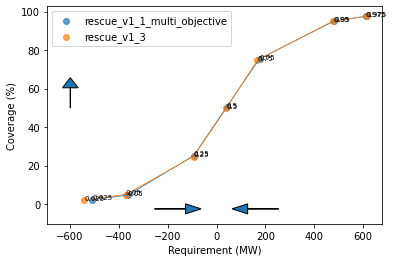

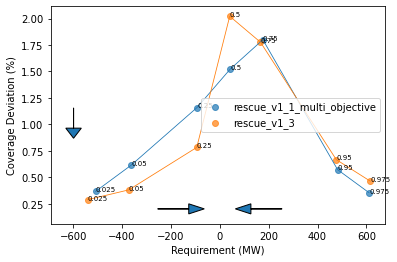

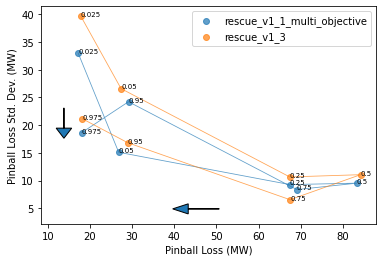

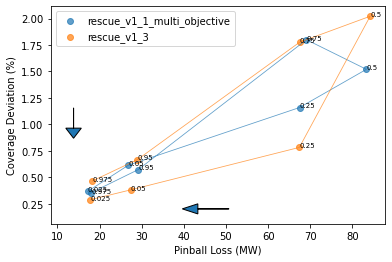

In [104]:
# Plotting

# Coverage vs. requirement
for model_name in models_to_compare:
    # Get coverage and requirement and average over CV folds
    coverage = model_data_dict[model_name]['coverage'].mean(axis=1)
    requirement = model_data_dict[model_name]['requirement'].mean(axis=1)
    # Plot
    plt.plot(requirement, 100*coverage, linewidth=0.8)
    plt.scatter(requirement, 100*coverage, alpha=0.7, label=model_name)
    
    # Add tau annotations
    tau_values = model_data_dict[model_name]['coverage'].index # Get tau values
    for i in range(len(tau_values)):
        plt.text(requirement.iloc[i], 100*coverage.iloc[i], tau_values[i], fontdict={'size':7})
    
axes = plt.gca() # Get axes of graph
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

# Plot desired direction for axes
# x-axis arrow(s)
plt.arrow(-0.2*(x_max-x_min) , y_min, 0.1*(x_max - x_min), 0, head_width=0.05*(y_max-y_min), head_length=0.05*(x_max-x_min))
plt.arrow(0.2*(x_max-x_min), y_min, -0.1*(x_max - x_min), 0, head_width=0.05*(y_max-y_min), head_length=0.05*(x_max-x_min))
# y-axis arrow# y-axis arrow
plt.arrow(x_min, 0.5*(y_min + y_max), 0, 0.1*(y_max - y_min), head_width=0.05*(x_max-x_min), head_length=0.05*(y_max-y_min))
    
plt.xlabel('Requirement (MW)')
plt.ylabel('Coverage (%)')
plt.legend()
plt.show()

# Average deviation of coverage from target vs. requirement
for model_name in models_to_compare:
    # Get average deviation of coverage from target (tau)
    coverage_data = model_data_dict[model_name]['coverage']
    coverage_deviation = pd.Series(index=coverage_data.index, dtype=float)
    for tau in coverage_data.index:
        coverage_tau = coverage_data.loc[tau]
        coverage_deviation.loc[tau] = np.sqrt(((coverage_tau - tau)**2).mean())
    # Get requirement and average over CV folds
    requirement = model_data_dict[model_name]['requirement'].mean(axis=1)
    # Plot
    plt.plot(requirement, 100*coverage_deviation, linewidth=0.8)
    plt.scatter(requirement, 100*coverage_deviation, alpha=0.7, label=model_name)
    
    # Add tau annotations
    tau_values = model_data_dict[model_name]['coverage'].index # Get tau values
    for i in range(len(tau_values)):
        plt.text(requirement.iloc[i], 100*coverage_deviation.iloc[i], tau_values[i], fontdict={'size':7})
    
axes = plt.gca() # Get axes of graph
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

# Plot desired direction for axes

# x-axis arrow(s)
plt.arrow(-0.2*(x_max-x_min) , y_min, 0.1*(x_max - x_min), 0, head_width=0.05*(y_max-y_min), head_length=0.05*(x_max-x_min))
plt.arrow(0.2*(x_max-x_min), y_min, -0.1*(x_max - x_min), 0, head_width=0.05*(y_max-y_min), head_length=0.05*(x_max-x_min))
# y-axis arrow
plt.arrow(x_min, 0.5*(y_min + y_max), 0, -0.1*(y_max - y_min), head_width=0.05*(x_max-x_min), head_length=0.05*(y_max-y_min))
    
plt.xlabel('Requirement (MW)')
plt.ylabel('Coverage Deviation (%)')
plt.legend()
plt.show()

# Standard deviation of pinball loss vs. pinball loss
for model_name in models_to_compare:
    # Get pinball loss and average over CV folds
    loss = model_data_dict[model_name]['pinball_loss'].mean(axis=1)
    # Get requirement and average over CV folds
    loss_deviation = model_data_dict[model_name]['requirement'].std(axis=1)
    # Plot
    plt.plot(loss, loss_deviation, alpha=0.7, linewidth=0.8)
    plt.scatter(loss, loss_deviation, alpha=0.7, label=model_name)
    
    # Add tau annotations
    tau_values = model_data_dict[model_name]['coverage'].index # Get tau values
    for i in range(len(tau_values)):
        plt.text(loss.iloc[i], loss_deviation.iloc[i], tau_values[i], fontdict={'size':7})
    
axes = plt.gca() # Get axes of graph
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

# Plot desired direction for axes
# x-axis arrow
plt.arrow(0.5*(x_min + x_max), y_min, -0.1*(x_max - x_min), 0, head_width=0.05*(y_max-y_min), head_length=0.05*(x_max-x_min))
# y-axis arrow
plt.arrow(x_min, 0.5*(y_min + y_max), 0, -0.1*(y_max - y_min), head_width=0.05*(x_max-x_min), head_length=0.05*(y_max-y_min))
    
plt.xlabel('Pinball Loss (MW)')
plt.ylabel('Pinball Loss Std. Dev. (MW)')
plt.legend()
plt.show()

# Average deviation of coverage from target vs. pinball loss
for model_name in models_to_compare:
    # Get average deviation of coverage from target (tau)
    coverage_data = model_data_dict[model_name]['coverage']
    coverage_deviation = pd.Series(index=coverage_data.index, dtype=float)
    for tau in coverage_data.index:
        coverage_tau = coverage_data.loc[tau]
        coverage_deviation.loc[tau] = np.sqrt(((coverage_tau - tau)**2).mean())
    # Get requirement and average over CV folds
    loss = model_data_dict[model_name]['pinball_loss'].mean(axis=1)
    # Plot
    plt.plot(loss, 100*coverage_deviation, alpha=0.7, linewidth=0.8)
    plt.scatter(loss, 100*coverage_deviation, alpha=0.7, label=model_name)
    
    # Add tau annotations
    tau_values = model_data_dict[model_name]['coverage'].index # Get tau values
    for i in range(len(tau_values)):
        plt.text(loss.iloc[i], 100*coverage_deviation.iloc[i], tau_values[i], fontdict={'size':7})
    
    
axes = plt.gca() # Get axes of graph
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

# Plot desired direction for axes
# x-axis arrow
plt.arrow(0.5*(x_min + x_max), y_min, -0.1*(x_max - x_min), 0, head_width=0.05*(y_max-y_min), head_length=0.05*(x_max-x_min))
# y-axis arrow
plt.arrow(x_min, 0.5*(y_min + y_max), 0, -0.1*(y_max - y_min), head_width=0.05*(x_max-x_min), head_length=0.05*(y_max-y_min))
    
plt.xlabel('Pinball Loss (MW)')
plt.ylabel('Coverage Deviation (%)')
plt.legend()
plt.show()

# 0. User Inputs
## 0.1 Model Training and Inference Parameters

In [7]:
# Name of the model to either be trained from scratch or to be restored for diagnostics. Recommend to include version number
model_name = 'rescue_v1_3'

# Target quantiles of the prediction 
PI_percentiles = np.array([0.025, 0.05, 0.25, 0.5,0.75, 0.95, 0.975]) # quantiles to predict

# Structural parameter of the ANN network
num_neurons = 10
activation_type = 'relu'

# Relative importance of model outputs. Order MUST match order of output variables
loss_wts = [np.sqrt(3), 1.0, 1.0, 1.0]

# Cross validation parameters
num_cv_folds = 10 # number of cross validation folds

# Training parameters
batch_size = 64 # size of each mini-batch in the SGD
max_epochs = 50 # Maximum number of epochs in training. In each epoch, each training data is used exactly once
optimizer_choice = 'adam' # Optimizer choice. Default to ADAM, a popular choice that have 1st and 2nd order momentum

# Early stopping parameters
early_stop_monitor = 'val_loss' # The metrics to watch when deciding whether to stop. Recommendation: Validation loss as in 'val_loss'
early_stop_min_delta = 0.5 # if the difference/decrease in loss is less than min_delta, the model is considered no longer improving
early_stop_patience = 3 # For number of patience epochs, observe if the model has improved more than min_delta
early_stop_verbosity = 1 # 0: no output, 1: some output, 2: full output

# Check points parameters
ckpt_monitor = 'val_loss' # Check points are only saved when there is an improvement in ckpt monitor

# Losses and Metrics log parameters
log_activation_freq = 0 # the frequency of logging hidden layer activation's histogram. Default to not log
log_update_freq = 'epoch' # The frequency of logging. Default to record at the end of every epoch

## 0.2 Diagnostics and Visualization Parameters

In [8]:
# Visualization parameters
eg_fold_for_visualization = 0 # the example fold of the trained models to use for plotting model output
default_dpi = 300 # dpi of the output graphics

# Define the mapping between internal feature (model input) name and feature label used in plotting
label_to_feature_map = {"Solar_RTPD_Forecast_T+1":"Solar Generation (MW)",
                       "Wind_RTPD_Forecast_T+1":"Wind Generation (MW)",
                       "Load_RTPD_Forecast_T+1":"Load (MW)",
                       "Days_from_Start_Date_T+1":"Date of Observation",
                       "Hour_Angle_T+1":"Hour",
                       "Day_Angle_T+1":"Month"}

# Define the mapping between internal response (model output) name and response label used in plotting
label_to_response_map = {"Net_Load_Forecast_Error_T+1":"Net Load",
                       "Load_Forecast_Error_T+1":"Load",
                       "Solar_Forecast_Error_T+1":"Solar",
                       "Wind_Forecast_Error_T+1":"Wind"}

# Define the mapping between internal response (model output) name and its type
# Type MUST be one of "load" or "generation". Used to determine sign-convention while plotting
response_type_map = pd.Series({"Net_Load_Forecast_Error_T+1":"load",
                               "Load_Forecast_Error_T+1":"load",
                               "Solar_Forecast_Error_T+1":"generation",
                               "Wind_Forecast_Error_T+1":"generation"})

# Training and validation loss comparison for multiple folds
x_jitter = 0.1
metrics_to_idx_map = {'Loss (MW)':0, 'Coverage Probability (%)':1}
metrics_to_compare = ['Loss (MW)', 'Coverage Probability (%)'] # choose in metrics_to_idx_map's keys

# Time series
ts_ranges = ['20170201','20170501','20170801','20171101'] # the example range of time series to plot

#TODO: Cycle for all years and all months

# Set this variable to false if not plotting a comparison to other reserves methods
is_plotting_comparative_methods = True
# a dictionary that has the method's name as key. and the method's reserve path as value
# Files MUST have an UP and a DOWN column, holding headroom and footroom in MW, both of which MUST be positive
s_drive_rescue_data = r"S:\E3 Projects\ARPA_E _PERFORM\Task_3_Machine_Learning\RESCUE\data\raw_data"
comparative_reserves_path = {"Histogram": os.path.join(s_drive_rescue_data, 
                                                       "Flex_Ramp_Req_RTPD_Histogram.csv"),
                             "Quant Reg": os.path.join(s_drive_rescue_data, 
                                                       "Flex_Ramp_Req_RTPD_Quantile_Reg.csv")}

# Quantiles used in the monthly coincendent comparison between historical and prediction. 
# As a suggestion should be set at the percentiles where headroom/footrooms are set
coincident_comp_quantiles = [0.025, 0.975]

# 1. Data Ingestion

Load in pre-processed trainval dataset that includes all input features/ output response(s) for both training and validation. Prepare the cross validation splitting masks. Set up directory structure to store intermediate (`log`, `checkpoints`) and final outputs (`models`, `outputs`,`diagnostics`).


In [9]:
# Load in/ Create folder structure for the current model
dir_str = utility.Dir_Structure(model_name = model_name)

# Read in input and output of the training and validation samples from data pipeline. 
# This should be an output of the data_preprocessing script
input_trainval = pd.read_pickle(dir_str.input_trainval_path)
output_trainval = pd.read_pickle(dir_str.output_trainval_path)

num_samples = input_trainval.shape[0]
num_outputs = output_trainval.shape[1]

# Use cross validation script to conduct intra-day consecutive trainval splitting. The number of folds is 
# determined by num_cv_folds. The data of the same day would not end up separately in training and validation
# to not overestimate model performance.
val_masks_all_folds = cross_val.get_CV_masks(input_trainval.index, num_cv_folds, dir_str.shuffled_indices_path)

Day block shuffling pre-determnined....
Done....
Creating train val masks for each fold....
Train and val masks are ready!


Conduct basic data validation to avoid some of the most common data pitfalls.


In [5]:
# Since historical data quatiles will be compared to model predictions, ensure model predictions exist at these exact quantiles
assert set(coincident_comp_quantiles)<= set(PI_percentiles)

# confirm the PI percentiles are symmetrical and 0.5 is one of the target quantile
for PI in PI_percentiles:
    assert np.allclose(1-PI_percentiles, PI_percentiles[::-1]), "Not all PI intervals are constructed symmetrically!"
assert 0.5 in PI_percentiles, "Median forecast (P50) must be produced!"

# Make sure input and output shape match
assert input_trainval.shape[0] == output_trainval.shape[0], "Input and output shape mismatch!"

# Make sure output and output weights shape match
assert output_trainval.shape[1] == len(loss_wts), "Number of 'loss_wts' must equal number of outputs"

# 2. Model Definition
Define the various component of the model that are active at various stage of the model life cycle. Before training: model structure, loss function. During training: call backs and metrics. After training: Saving functions. 

## 2.1 Model Structure.
The RESCUE model is built with the Keras [functional API](https://www.tensorflow.org/guide/keras#model_subclassing). As it stands right now, it is a two layer ANN network with a pre-processing normalization layer. Rectified linear units (RELU) is used as the activation function for the hidden layers, while the last layer is a direct linear regression.                        

In [9]:
# Create a model that include the normalization layer
inputs = tf.keras.Input(shape=input_trainval.shape[1:])

# Create a Normalization layer and set its internal state using the training data
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(name = 'Normalization')
norm_inputs = normalizer(inputs)

# A two-layer ANN network for regression
dense1 = tf.keras.layers.Dense(num_neurons, activation=activation_type)
hidden1 = dense1(norm_inputs)
dense2 = tf.keras.layers.Dense(num_neurons, activation=activation_type)
hidden2 = dense2(hidden1)
dense3 = tf.keras.layers.Dense(num_outputs)
outputs = dense3(hidden2)

# define model from inputs to outputs
rescue_model = tf.keras.Model(inputs, outputs)

## 2.2 Loss Function

The pinball loss function is used here to provide a quantile forecast rather than a median forecast. With increasing sample size, the pinball loss would converge to the quantile forecast of a variable conditional on the input variable. The quantile is given by a parameter `tau`, which is set in the user input as PI percentiles. 

One property of the pinball loss is that for 0% and 100% percentile, the pinball loss is always 0 no matter the model and parameter choice, while the median forecast have the highest loss. So comparing the losses across different quantiles makes little sense, and is advised against. For more information on pinball losses, check out [this wiki](https://en.wikipedia.org/wiki/Quantile_regression).

In case of multi-output, multi-objective regression, the loss corresponding to each output can be weighted based on the importance given to each output. The loss that the model will ultimately try to minimize would be the weigted average pinball loss of all the outputs. In the specific and common case of net load co-trained with wind,solar, and load, the recommended weight raio is $\sqrt{3}$:1:1:1.

In [10]:
class PinballLoss(tf.keras.losses.Loss):
    
    def __init__(self, tau=0.5, loss_wts=[1], name="pinball_loss", **kwargs):
        super().__init__(name=name)
        self.tau = tau # the target quantile
        self.loss_wts = loss_wts # Relative importance of loss corresponding to each output

    def call(self, y_true, y_pred):
        err = y_true - y_pred # the convention is always true - pred
        # essentially, quantile regression takes two region. For values bigger than the quantile forecast,
        # they are weighted by 1-tau, while for values smaller than the forecast it's weighted by tau.
        loss_for_each_output_var_of_each_sample = tf.math.maximum(self.tau * err, (self.tau - 1) * err)
        # Get weighted avg loss for each sample
        loss_for_each_sample = tf.math.reduce_mean(tf.math.multiply(loss_for_each_output_var_of_each_sample, self.loss_wts),
                                                   axis = 1)
        # Now get a single loss across all samples that make up the batch
        skewed_mse = tf.math.reduce_mean(loss_for_each_sample, axis=0)

        return skewed_mse

## 2.3 Metrics

In tensorflow terminology, metrics are quantities that are calculated as the training goes on to aid your judgement on model's fitness and completeness. In our use cases, we define two metrics for this purpose: coverage probability and average interval width.

For prediction intervals, **coverage probability** refers to how often are the actual forecast included in the prediciton interval bands. Here we slightly modify the definition and refers to how often are the actual forecast smaller than the target quantile. For a well behaving model, the CP would converge to target quantile tau.

For **average interval width**, it normally refers to the width of a prediction interval band. Again, we make a slight modification here. Since in practice, the forecast for quantiles above 50% are upwards reserve and normally positive, and below 50% are downwards reserve and normally negative, we are simply using the quantile forecast's absolute distance to 0 as the interval width here. For interpretation, we are looking for smaller requirement for better band width, but also high flexibitliy wrt to varying condidtions.


In [11]:
class CoverageProbability(tf.keras.metrics.Metric):
    def __init__(self, name = 'CP',**kwargs):
        super(CoverageProbability, self).__init__(name = name, **kwargs)
        self.coverage_probability = self.add_weight(name = 'CP', initializer="zeros", dtype = tf.float64)
        # the cumulative number of samples and the number of samples smaller than current quantile forecast
        self.cum_n_samples = self.add_weight(name = 'n_samples', initializer="zeros", dtype = tf.int32)
        self.cum_n_covered = self.add_weight(name = 'n_covered', initializer="zeros", dtype = tf.int32)
        
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # the state would be updated everytime we have a new calculation
        self.cum_n_samples.assign_add(tf.size(y_pred, out_type=tf.int32))
        self.cum_n_covered.assign_add(tf.math.count_nonzero(tf.math.less_equal(y_true,y_pred), dtype = tf.int32))
        # cp = n_covered/n_samples
        self.coverage_probability.assign(tf.math.divide(self.cum_n_covered, self.cum_n_samples))

    def result(self):
        return self.coverage_probability

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.coverage_probability.assign(0.0)
        
class AverageIntervalWidth(tf.keras.metrics.Metric):

    def __init__(self, name='AIW', **kwargs):
        super(AverageIntervalWidth, self).__init__(name=name, **kwargs)
        self.average_interval_width = self.add_weight(name='AIW', initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # the state would be updated everytime we have a new calculation
        self.average_interval_width.assign(tf.math.reduce_mean(y_pred))

    def result(self):
        return self.average_interval_width

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.average_interval_width.assign(0.0)

## 2.4 Callbacks

In tensorflow terminology, callbacks are functions that get executed with certain frequency during training. For our purpose, all the callbacks happen once per epoch and we are using three types of callbacks: Early stopping, check points, and tensor boards. Saving the model is not necessarily a callback, but it also get executed once after the training for the model is complete, so is included in this segment.

1. Early stopping stops the training when certain criteria is met. In general the criteria is that when `monitor` did not improve by more than `min_delta` in `patience` epoch(s), then the training is stopped. This is a way to effectively prevent overfitting to the training data, so the monitor is most often validation loss.  
2. Check points are periodical snap shot of parameter weights saved in case the model training is unexpectedly stopped.  We are saving the `checkpoints`,`logs`, and`trained models` in different folders for different taus and folds.
3. Saving is very similar to check points. Difference is that check points are conducted at the end of every epoch, while saving only happens at the end of training session.
4. The tensorboard callback allow us to visualize and observe losses and all metrics in a pre-compiled tensorboard interface. It can even visualize losses and metrics for multiple folds and taus.

In [12]:
# Early stopping stops the training when certain criteria is met.
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, 
                                                     patience=early_stop_patience, verbose=early_stop_verbosity)

# For the save best only parameter: we will overwrite the current checkpoint if and only if the `val_loss` 
# score has improved. Different fold and tau would end up in different ckpts_dir folder
def get_cb_check_points(tau, fold_idx):
    # make sure models for different tau go to different directories
    ckpts_dir = os.path.join(dir_str.ckpts_dir, "tau_{:.1%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(ckpts_dir):
        os.makedirs(ckpts_dir)
    cb_check_points = tf.keras.callbacks.ModelCheckpoint(filepath=ckpts_dir, save_best_only=True, monitor= ckpt_monitor, verbose=0)
    return cb_check_points


# Currrently not logging the histogram of activation and embedding layers. Write log per epoch.
def get_cb_tensor_board(tau, fold_idx):
    # make sure models for different tau and fold would get logged in different directory
    logs_dir = os.path.join(dir_str.logs_dir, "tau_{:.1%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(logs_dir):
        os.makedirs(logs_dir)
    cb_tensor_board = tf.keras.callbacks.TensorBoard(logs_dir, histogram_freq= log_activation_freq, 
                                                     embeddings_freq=0,  update_freq=log_update_freq)  
    return cb_tensor_board

# Save the model by the end of each training session. Might be replacible by checkpoints.
def save_rescue_model(model, tau, fold_idx):
    # make sure models for different tau and fold would get logged in different directory
    models_dir = os.path.join(dir_str.models_dir, "tau_{:.1%}".format(tau),"fold_#{}".format(fold_idx))
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    
    model.save(models_dir)
    return None   

# 3. Model Training

Training is the process where the parameter of a model changes to reduce some loss function. In our specific case, we are conducting training separtely for each target quantile and each fold. We first split data into training and validation based on current fold number, and then initialize a new model to fit to the training data until the pinball loss meet some stopping criteria, i.e. showing no significant decrease.


In [ ]:
rescue_model_set = {} # intialized container for TF models. Indexed by (tau, fold_idx)
history = {} # intialized container for the training history of models. Indexed by (tau, fold_idx)

# loop through different target quantiles and cross validation folds
for tau in PI_percentiles:
    print("Training model for Prediction interval: {:.1%}".format(tau))
    for fold_idx in range(num_cv_folds):
        print("Cross Validation fold #", fold_idx+1)
        
        # Split into training and validation dataset based on the CV validation masks generated in section 1.
        input_train, output_train = input_trainval[~val_masks_all_folds[fold_idx]], output_trainval[~val_masks_all_folds[fold_idx]]
        input_val, output_val = input_trainval[val_masks_all_folds[fold_idx]], output_trainval[val_masks_all_folds[fold_idx]]
        
        # retain value only and cast to 'float32'. Single precision calculate a lot faster than double precision.
        input_train = input_train.values.astype('float32')
        output_train = output_train.values.astype('float32')
        input_val = input_val.values.astype('float32')
        output_val = output_val.values.astype('float32')

        # Using tf.data API to batch and shuffle the dataset. For shuffling, the buffer size should be bigger than the total 
        # sample count. Or else only the first buffle size of samples would be shuffled 
        train_ds = tf.data.Dataset.from_tensor_slices((input_train, output_train)).shuffle(buffer_size= num_samples).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((input_val, output_val)).shuffle(buffer_size = num_samples).batch(batch_size)

        # Make a fresh clone of the rescue model for the specific quantile and fold
        rescue_model_set[(tau, fold_idx)] = tf.keras.models.clone_model(rescue_model)
        # For some layers the paramers are not trainable, and is adapted at the begining to data. E.g.:Normalization layer 
        rescue_model_set[(tau, fold_idx)].get_layer('Normalization').adapt(input_trainval.values)
        # Compiling the loss, optimizer, metrics, and model into one compiled instance
        rescue_model_set[(tau, fold_idx)].compile(loss=PinballLoss(tau=tau, loss_wts=loss_wts),
                                                  optimizer=optimizer_choice, metrics=[CoverageProbability(),AverageIntervalWidth()])
        
        # The training process. Passing in callbacks to use in mid training 
        history[(tau, fold_idx)]= rescue_model_set[(tau, fold_idx)].fit(train_ds, validation_data=val_ds, epochs=max_epochs,
                                                                        callbacks=[cb_early_stopping, get_cb_tensor_board(tau, fold_idx)])
        
        # Save the trained rescue model for each target percentile and fold
        save_rescue_model(rescue_model_set[(tau, fold_idx)], tau, fold_idx)


## 4. Re-loading trained model

In [18]:
# # Load models
# rescue_model_set = {}

# # Initialize container for the inference result for different quantiles/CV folds
# multi_index_tau_folds = pd.MultiIndex.from_product([PI_percentiles, range(num_cv_folds), output_trainval.columns.values],
#                                                    names = ['Quantiles','Fold ID', "Output_Name"])
# pred_trainval = pd.DataFrame(index = input_trainval.index, columns = multi_index_tau_folds) 

# for tau in PI_percentiles:
#     for fold_idx in np.arange(num_cv_folds):
#         # Get path to trained model .pb file
#         path_to_curr_model = os.path.join(dir_str.models_dir, "tau_{:.1%}".format(tau), "fold_#{}".format(fold_idx))
        
#         # Load model and save in dict
#         rescue_model_set[(tau, CV_fold)] = tf.keras.models.load_model(path_to_curr_model, compile = False)
        
#         # Deploy model on the trainval data and record inference results
#         pred_trainval.loc[:, (tau, fold_idx)] = rescue_model_set[(tau,fold_idx)].predict(input_trainval.values)

AttributeError: 'Model' object has no attribute 'loss'

## 4. Model Inference
After the model is trained, we use it to produce quantile predictions on the entire trainval set. Note that the training history is also transformed into a np array here for easy storage and visualizaiton.

In [ ]:
# Initialize container for the inference result for different quantiles/CV folds
multi_index_tau_folds = pd.MultiIndex.from_product([PI_percentiles, range(num_cv_folds), output_trainval.columns.values],
                                                   names = ['Quantiles','Fold ID', "Output_Name"])
pred_trainval = pd.DataFrame(index = input_trainval.index, columns = multi_index_tau_folds) 

# Initialize container for the training loss and metric history
num_metrics = len(history[(PI_percentiles[0], 0)].history)
training_history = np.ones((len(PI_percentiles), num_cv_folds, max_epochs, num_metrics))*np.nan

# looping through all target percentiles and CV folds
for i,tau in enumerate(PI_percentiles):
    print ('Inferring on quantile of {:.1%}'.format(tau))
    for fold_idx in range(num_cv_folds):
        # Record training loss and metrics history
        num_epochs = len(history[(tau, fold_idx)].history['loss'])
        training_history[i,fold_idx,:num_epochs,:] = pd.DataFrame(history[(tau, fold_idx)].history).values
        
        # Deploy model on the trainval data and record inference results
        pred_trainval.loc[:, (tau, fold_idx)] = rescue_model_set[(tau,fold_idx)].predict(input_trainval.values)
        
#Output inference result and training history to hard drive        
pred_trainval.to_pickle(dir_str.pred_trainval_path)
np.save(dir_str.training_hist_path, training_history)

# 5. Diagnostics and Visualizations
This section includes an expanding set of diagnostics and visualization tool to assess the performance of RESCUE model, and check whether the model's behavior adheres to our intuition. As a standalone section, you should be able to skip **section 2-4** and directly start runing **section 5** after **section 1**. First we load in the quantile prediction made in the inference section and the training history from the training section. They should all be on the hard drive already if previously trained to completion and saved. Then, users can optionally read in reserve produced by other methodology for comparison, by providing associated inputs in **section 0.2**.

In [ ]:
# load in quantile prediction
if os.path.exists(dir_str.pred_trainval_path):
    pred_trainval = pd.read_pickle(dir_str.pred_trainval_path)
else:
    print('No quantile prediction found! Run section 4 first!')
# load in training history
if os.path.exists(dir_str.training_hist_path):
    training_hist = np.load(dir_str.training_hist_path)
else:
    print('No training history found!')
    
# Read in comparison reserves data, if user provided a path to it
if is_plotting_comparative_methods:
    comparative_reserves = {}
    for comp_name, path in comparative_reserves_path.items():
        comparative_reserves[comp_name] = pd.read_csv(path, index_col = 0, parse_dates = True)
        # Extract appropriate time-points from historical reserves data
        comparative_reserves[comp_name] = comparative_reserves[comp_name].loc[input_trainval.index]

## 5.1 Numeric Metrics
The sections below contains numeric metrics generated for the RESCUE model.
### 5.1.1 Metrics matrix
For the metrics matrix, it places different prediction interval on different columns and different metrics on the rows. The metrics currently includes:
- coverage
- requirement
- exceeding
- closeness
- max exceedance
- reserve ramp rate
- pinball loss

The terminology for the metrics largely follows [CAISO FRP](http://www.caiso.com/InitiativeDocuments/AppendixC-QuantileRegressionApproach-FlexibleRampingProductRequirements.pdf) convention. For more information, please refer to the documentation within metrics module for each of the metrics

In [ ]:
# Calculated metrics value for the RESCUE method
metrics_value = metrics.compute_metrics_for_all_taus(output_trainval, pred_trainval, val_masks_all_folds, dir_str)

# print out net load related metrics
for output in metrics_value.columns.levels[1]:
    if "Net_Load" in output:
        print("="*84,"\n", output, "\n", "="*84)
        print(metrics_value.xs(output, axis=1, level = 'Output_Name'))

### 5.1.2 Quantile crossing
Theoretically, for any type of forecast error, larger quantiles should always have a higher(more positive) numeric value. However, when this is not the case with two quantiles, it is called an instance of quantile crossing. This section characterizes the numbers of occurence for this phenomenom.

In [ ]:
metrics.n_crossings(pred_trainval).style.format("{:.2%}")

## 5.2 Tensorboard
Tensorboard is a built-in visualization tool to visualize the losses and metrics during multiple training processes. Use `tensorboard --logdir dir_str.logs_dir` to invoke it in the command line (replace `dir_str.logs_dir` with the folder it's referring to). This is also the reason we did not plot training history for each epoch, as it's done in tensorboard already

**What to look for**: Training loss should converge in the last few epochs. Validation loss should not trail behind training loss by too much.

## 5.3 Visualization
Visualize the forecast bias and uncertainty's change w.r.t to different input features. Check if the visualization corroborate or contradict our intuition. Many contradictions would constitute a red flag for model's fidelity.

1. One fold at a time: Since visualizing multiple folds' output at the same time brings visual chaos, we use an example fold from the trained models as the basis for visualization.
2. Sign convention: The sign convention is managed such that headroom requirement will always be shown above y = 0 and footroom will always be shown below y = 0, irrespective of whether you are looking at load-based or a generation-based forecast uncertainty. Practically this means that for load, upper quadrants are for actual load>predicted load; and for generation, actual generation < predicted generation. 
3. Mulitple outputs: Different outputs should all be visuallized.


In [ ]:
from importlib import reload
reload(diagnostics)

In [ ]:
# Only visualize for the validation predictions
pred_val = metrics.get_validation_preds(pred_trainval, val_masks_all_folds)

# Based on the traditional foot room and headroom notion, we should have <0.5 quantiles represent footroom, 
# and >0.5 quantiles represent headroom. Therfore, we flip the generation side quantile prediction's sign
# and quantile postiion to conform to this sign convention
load_type_response = response_type_map[response_type_map == "load"].index
idx = pd.IndexSlice # alias for pandas slicer

# switching the headroom and footroom columns for the generation side errors. 
# I.e. The PI quantiles would be switched to the 1-PI position
for PI in PI_percentiles:
    if PI<0.5:
        sym_PI = round(1-PI, 4) #avoiding numeric issue
        transfer_array = pred_val.loc[:,idx[PI, load_type_response]].values
        pred_val.loc[:,idx[PI, load_type_response]] = pred_val.loc[:,idx[sym_PI, load_type_response]].values
        pred_val.loc[:,idx[sym_PI, load_type_response]] = transfer_array

# Flip the sign for the generaion side errors and reserves in addition to switching position
pred_val.loc[:, idx[:, load_type_response]] *=-1
output_trainval.loc[:, load_type_response] *= -1

# This function essentially puts any given plotting function in a loop, 
# which goes thru all the responses listsed in the label_to_response_map
loop_thru_curr_responses = functools.partial(diagnostics.loop_thru_responses, pred_val = pred_val, output_trainval = output_trainval, 
                                             label_to_response_map = label_to_response_map, plot_dir = dir_str.plots_dir,
                                             is_plotting_comparative_methods = is_plotting_comparative_methods)

### 5.3.1 Forecast uncertainty grouped by input features
Visualize the forecast bias and uncertainty's change w.r.t to different input features. Check if the visualization corroborate or contradict our intuition. Many contradictions would constitute a red flag for model's fidelity.

**What to expect with net load forecast:** <br>
1. **Forecast uncertainty v.s. Solar production**: Forecast uncertainty should be the highest for medium solar production, and low during both no solar and full solar periods.
2. **Forecast uncertainty v.s. Wind production**:  Wind should have less effect on forecast uncertainty than solar. Increases with higher wind production
3. **Forecast uncertainty v.s. Load**: Forecast uncertainty should increase with higher load.
4. **Forecast uncertainty v.s. Hours**: Sunset and sunrise hours are associated with high amount of uncertainty. No solar night time hours should have low uncertainty.
5. **Forecast uncertainty v.s. Season**: Highly dependent on local climate type. For mediterranean climate, expect little to no change, with a slight increase in winter. For continental climate, expect higher uncertainty in summer due to precipitation. For desert climate, expect smaller uncertainty year round, while expecting higher uncertainty year round for oceanic and tropical climates. For monsoon dominated climate, expect higher uncertainty in monsoon season (usually summer).
6. **Forecast uncertainty v.s. Date of installation**: Highly dependent on modeled BA. If the BA experience significant renewable growth, expect increasing uncertainty with time.

In [ ]:
# Demonstrate the change in forecast uncertainty with respect to Solar, wind and load
for feature, feature_label in label_to_feature_map.items():
    # if looking at Hour and Month, binning is derived from index
    if feature_label == "Hour":
        feature_discretized = pred_val.index.hour
    elif feature_label == 'Month':
        feature_discretized = pred_val.index.month
    else:
        # else the label is derived from dicretizing a continuous input
        feature_discretized = diagnostics.discretize_input(input_trainval[feature])
        if feature_label == 'Date of Observation':
            # for 'Date of Observation', we add the starting date so it shows up as a historical data
            feature_discretized = (pd.Timestamp(input_trainval.index[0].date()) 
                                   + feature_discretized.astype('int')*pd.Timedelta('1D'))
    
    comparative_reserve_groupedby_input = {n:v.groupby(feature_discretized.values).mean() 
                                           for (n,v) in comparative_reserves.items()}
    
    
    plot_uncertainty_groupedby_feature = functools.partial(diagnostics.plot_uncertainty_groupedby_feature, 
                                                           input_var_discretized = feature_discretized, 
                                                           input_var_name = feature_label)
    title_fn = lambda response: '{}_vs_{}.svg'.format(response, feature_label)
    fig, ax = loop_thru_curr_responses(plot_uncertainty_groupedby_feature, title_fn,
                                       comparative_reserves = comparative_reserve_groupedby_input)

## 5.3.2 Monthly comparison of the coincident quantile between Predictions and Truth
The goal of this section is to compare model prediction with historical error quantile. The goal is straightforward but the method is nothing but, since there is no direct way we can observe the historical error quantile.

Over a period of time tho, we can use the quantiles of all errors occured in this period to approximate the true quantile of the historical error. For a quantile, we picked the hour that the error falls on this quantile, and plot the coincident model prediction of the same quantile. The authors decided that the most interesting form of this plot, is to aggregate all errors of the same month and hour, and plot out the hourly coincident error and prediction. Reserves calculated from other methods can be overlaid on top for comparison with model predicted reserves. See explainition under **section 5.3** for sign convention.

**What to expect from a well trained model:**
1. True forecast errors are generally comprised within the extent of model predictions
2. Model's predictions doesn't fall well beyond true forecast errors all the time - which would be an indication that the model is being too conservative and thus wasteful of reserves. We're aiming to achieve target coverage while minimizing amount of reserves held to do so
3. Median quantile of true forecast errors matches well with median quantile of model predictions of forecast errors



In [ ]:
comparative_reserves_groupedby_hour = {n:v.groupby(v.index.hour).mean() 
                                      for (n,v) in comparative_reserves.items()}


plot_coincident_quantile_comp = functools.partial(diagnostics.plot_coincident_quantile_comp, 
                                                  quantiles_list= coincident_comp_quantiles)
title_fn = lambda response:"coincident_pred_hist_comparison_{}.svg".format(response)
fig, ax = loop_thru_curr_responses(plot_coincident_quantile_comp, title_fn,
                                   comparative_reserves = comparative_reserves_groupedby_hour)
    

### 5.3.3 Example Time series
Visualize the quantile forecast for a few example days.


**What to look for**:
1. **Smoothness**: Is the reserve interval band changing continuously?
2. **Coverage**: How good is the reserve interval band covering the true forecast error? The more the better.
3. **Exceeding**: What kind of condition seems to lead to exceedance? Hopefully it should be extreme

In [ ]:
# Iterate through each of the time series range to be plotted
for ts_range in ts_ranges:
    comparative_reserves_TS = {n:v.loc[ts_range] 
                               for (n,v) in comparative_reserves.items()}
    
    
    plot_example_ts = functools.partial(diagnostics.plot_example_ts, ts_range = ts_range)
    title_fn = lambda response:"{}_on_{}.svg".format(response, ts_range)
    loop_thru_curr_responses(plot_example_ts, title_fn, comparative_reserves = comparative_reserves_TS)


## 5.3.4 Model performance in different CV folds
Visualizing model performance for all the cross validation folds across training and validation sets. An important tool in assessing the generalizability of the model.

**What to look for:**
1. Distance between training and validation. Smaller distance signifies a small amount of expected performance drop betweeen seen and unseen data, hence better generalizability.
2. Spread among different validation folds: The smaller the spread, the more invariant the model is to its data, and hence better generalizability.

In [ ]:
fig, _ =  diagnostics.plot_compare_train_val(training_hist, PI_percentiles,      
                                             metrics_to_idx_map, metrics_to_compare, x_jitter =x_jitter)

fig.savefig(os.path.join(dir_str.plots_dir, 'Train_Val_Comparison.png'), dpi=default_dpi, bbox_inches = 'tight')

### Under construction: Multi-model comparison: Pareto Improvement

Archived code: Use `tf.GradientTape` for very fine grained control.